# 0. Imports and settings

In [21]:
# Load libraries
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import KDTree
from scipy import stats
import mplhep
from collections import namedtuple

# Set mpl settings
plt.style.use(mplhep.style.CMS)

# 1. Global classes and functions

In [22]:
def readData(path, printBranches=False):
    data = uproot.open(path)['Events']
    
    if printBranches:
        for branch in data:
            print(branch)
        return data
    else:
        return data

In [23]:
class Candidates:

    def __init__(self, data):
        puppi_pt = data["l1tLayer2DeregionizerCands_pt"].array()
        puppi_pt_sort = ak.argsort(puppi_pt)
        self.pt = puppi_pt[puppi_pt_sort]
        self.eta = data["l1tLayer2DeregionizerCands_eta"].array()
        self.phi = data["l1tLayer2DeregionizerCands_phi"].array()

In [47]:
class Jet:

    class Seeds:
        def __init__(self, data, branch):
            self.pt = data[branch+"Jets_dau0_pt"].array()
            self.eta = data[branch+"Jets_dau0_eta"].array()
            self.phi = data[branch+"Jets_dau0_phi"].array()

    def __init__(self, data, branch, colour, marker):
        self.name = branch
        self.colour = colour
        self.marker = marker
        
        self.pt = data[branch+"Jets_pt"].array()
        self.eta = data[branch+"Jets_eta"].array()
        self.phi = data[branch+"Jets_phi"].array()

        self.seeds = self.Seeds(data=data, branch=branch)

    def changeColour(self, newColour):
        self.colour = newColour
    def changeMarker(self, newMarker):
        self.marker = newMarker

In [48]:
def jetConstructor(data, jetParams):
    jets = []
    for jet in jetParams:
        print("Loading {}".format(jet))
        #print(data)
        jets.append(Jet(data, jet, *jetParams[jet]))
    
    return jets

# 2. Plotting functions

In [49]:
def plotter(jets, jetCap=6, r=0.4, Ev=0, jetCircle=False):
    fig, ax = plt.subplots(figsize=(18,18))
    #nJets = min( [ len(jet["pt"][Ev]) for jet in jets ] )
    #jetCap = min(jetCap, nJets)
    
    ax.scatter(cands["eta"][Ev], cands["phi"][Ev], c=np.log(cands["pt"][Ev]), cmap="Greys", label="PUPPI Candidates")    # Plot PUPPI candidates
    #ax.scatter(cands["eta"][Ev], cands["phi"][Ev], label="PUPPI Candidates")    # Plot PUPPI candidates
    for jetType in jets:    # Iterate over the different types of jets
        eta, phi, pt, c, mark = jetType["eta"][Ev], jetType["phi"][Ev], jetType["pt"][Ev], jetType["colour"], jetType["marker"]
        seed_eta, seed_phi = jetType["seeds"]["eta"][Ev], jetType["seeds"]["phi"][Ev]
        
        ax.scatter(eta[:jetCap], phi[:jetCap], s=30*np.log(pt[:jetCap]), label=jetType["name"], marker=mark, edgecolors=c, facecolor='none')    # Plot the jets up to the jet cap
        for jetIdx, _ in enumerate(pt[:jetCap]):    # Iterate over the jets
            if jetCircle:    # Places the jet circle over the axis of the jet
                ax.add_patch(plt.Circle((eta[jetIdx], phi[jetIdx]), r, edgecolor=c, facecolor='none', linewidth=1, linestyle="--"))    # Add circle around given jet to the current axis
                """ Phi wrapping """
                if phi[jetIdx] + r > np.pi:
                    ax.add_patch(plt.Circle((eta[jetIdx], -2*np.pi+phi[jetIdx]), r, edgecolor=c, facecolor='none', linewidth=1, linestyle="--"))
                if phi[jetIdx] - r < -np.pi:
                    ax.add_patch(plt.Circle((eta[jetIdx], 2*np.pi+phi[jetIdx]), r, edgecolor=c, facecolor='none', linewidth=1, linestyle="--"))
            else:    # Places the circle around the seed
                ax.add_patch(plt.Circle( ( seed_eta[jetIdx], seed_phi[jetIdx] ), r, edgecolor=c, facecolor='none', linewidth=1, linestyle="--" ))    # Add circle around given jet to the current axis
                """ Phi wrapping """
                if seed_phi[jetIdx] + r > np.pi:
                    ax.add_patch(plt.Circle((seed_eta[jetIdx], -2*np.pi+seed_phi[jetIdx]), r, edgecolor=c, facecolor='none', linewidth=1, linestyle="--"))
                if phi[jetIdx] - r < -np.pi:
                    ax.add_patch(plt.Circle((seed_eta[jetIdx], 2*np.pi+seed_phi[jetIdx]), r, edgecolor=c, facecolor='none', linewidth=1, linestyle="--"))
                
            
    ax.set_xlabel('$\eta$')    # Set x and y labels
    ax.set_ylabel('$\phi$')    #
    ax.set_ylim((-np.pi, np.pi))
    ax.set_xlim((-5, 5))
    ax.set_aspect('equal', 'box')
    ax.set_title("Level 1 jets. Event = {}".format(Ev))
    #mplhep.cms.label(label="Preliminary. Jet classification by three different algorithms. Event = {}".format(Ev), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    ax.legend()
    return ax

In [85]:
def jetPlotter(Ev, jets, jetCap, r=0.4, jetCircle=False):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(cands.eta[Ev], cands.phi[Ev], c=np.log(cands.pt[Ev]), cmap="Greys", label="PUPPI Candidates")    # Plot PUPPI candidates
    
    for jetType in jets:    # Iterate over the different types of jets
        eta, phi, pt = jetType.eta[Ev], jetType.phi[Ev], jetType.pt[Ev]#[:jetCap]
        seed_eta, seed_phi, seed_pt = jetType.seeds.eta[Ev], jetType.seeds.phi[Ev], jetType.seeds.pt[Ev]
        name, mark, col = jetType.name, jetType.marker, jetType.colour
        
        ax.scatter(eta, phi, s=30*np.log(pt), label=name, marker=mark, edgecolors=col, facecolor='none')    # Plot the jets up to the jet cap
        for i, _ in enumerate(pt[:jetCap]):    # Iterate over the jets
        #for i in range(jetCap):
            if jetCircle:
                ax.add_patch(plt.Circle((eta[i], phi[i]), r, edgecolor=jetType.colour, facecolor='none', linewidth=1, linestyle="--"))    # Add circle around given jet to the current axis
                if phi[i] + r > np.pi:
                    ax.add_patch(plt.Circle((eta[i], -2*np.pi+phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
                if phi[i] - r < -np.pi:
                    ax.add_patch(plt.Circle((eta[i], 2*np.pi+phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
    
            else:    # Places the circle around the seed
                ax.add_patch(plt.Circle((seed_eta[i], seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--" ))    # Add circle around given jet to the current axis
                """ Phi wrapping """
                if seed_phi[i] + r > np.pi:
                    ax.add_patch(plt.Circle((seed_eta[i], -2*np.pi+seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
                if seed_phi[i] - r < -np.pi:
                    ax.add_patch(plt.Circle((seed_eta[i], 2*np.pi+seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
    
    
    ax.set_xlabel('η')    # Set x and y labels
    ax.set_ylabel('ϕ')    #
    ax.set_ylim((-np.pi, np.pi))
    ax.set_xlim((-5, 5))
    ax.set_aspect('equal', 'box')
    #ax.set_title("Level 1 jets. Event = {}".format(Ev))
    #mplhep.cms.label(label="Preliminary. Jet classification by three different algorithms. Event = {}".format(Ev), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    ax.legend()
    return ax

# Wide cone Jets

In [51]:
ntuple = "~/cernbox/wideCone/wideConeSig.root"
sig = readData(ntuple, printBranches=False)

In [52]:
cands = Candidates(data=sig)

In [53]:
jetParams = {
    "wideHSC" : ("red", "^"),
    "scPuppi" : ("blue", "X")
}

wideHSC, sc = jetConstructor(data=sig, jetParams=jetParams)

Loading wideHSC
Loading scPuppi


In [80]:
jetType=wideHSC
Ev=1

eta, phi, pt = jetType.eta[Ev], jetType.phi[Ev], jetType.pt[Ev]#[:jetCap]
seed_eta, seed_phi, seed_pt = jetType.seeds.eta[Ev][:jetCap], jetType.seeds.phi[Ev][:jetCap], jetType.seeds.pt[Ev][:jetCap]
name, mark, col = jetType.name, jetType.marker, jetType.colour

NameError: name 'jetCap' is not defined

<AxesSubplot:xlabel='η', ylabel='ϕ'>

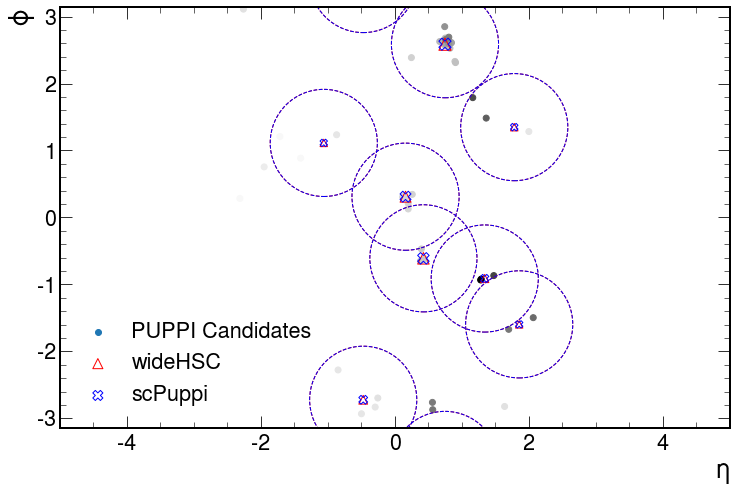

In [86]:
jetPlotter(Ev=1, jets=[wideHSC, sc], jetCap=50, r=0.8, jetCircle=True)

# Regular Jets

In [2]:
path = "~/cernbox/outputFiles/seedSize/TTbar/TTbarTrimmed.root"
data = uproot.open(path)['Events']

## Histogrammer illustrator

In [ ]:
ev=7
cap=5
fig, ax = plt.subplots(figsize=(12, 12))
#fig, ax = plt.subplots()
ax.hist2d(
    cands["eta"][ev], cands["phi"][ev],
    weights=np.log(cands["pt"][ev]),
    bins=50,
    cmap="Reds"
#    range=[ (-5, 5), (-np.pi, np.pi) ]
)

def Square(ax):
    ax.add_patch(plt.Rectangle((0,0), 10, 10))
    
ax.add_patch(plt.Rectangle((-0.5, -2.1), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle((-0.5, -2.35), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle((-0.5, -2.6), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))

ax.add_patch(plt.Rectangle( (-0.75, -2.1), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-0.75, -2.35), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-0.75, -2.6), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))

ax.add_patch(plt.Rectangle( (-1.0, -2.10), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-1.0, -2.35), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-1.0, -2.6), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
    
#ax.set_title("Phase 1 Histogrammer")
mplhep.cms.label(label="Phase 1 histogrammer".format(), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
ax.set_xlabel("η\eta"); ax.set_ylabel("ϕ\phi")

ax.scatter(gen["eta"][ev][:cap], gen["phi"][ev][:cap], s=30*np.log(gen["pt"][ev][:cap]), marker="X", edgecolors="black", facecolor='none', label="Generator jets")
ax.set_xlabel('η\eta')    # Set x and y labels
ax.set_ylabel('ϕ\phi')    #
ax.set_ylim((-np.pi, np.pi))
ax.set_xlim((-5, 5))
ax.set_aspect('equal', 'box')
ax.legend()
plt.show()

## Cutting jets on pT

In [ ]:
def ptCutter(jetDict, cut=25):
    filtArray = jetDict["pt"][:] > cut
    jetDict["pt"] = jetDict["pt"][:][filtArray]
    jetDict["eta"] = jetDict["eta"][:][filtArray]
    jetDict["phi"] = jetDict["phi"][:][filtArray]
    return jetDict

In [ ]:
sc_cut = ptCutter(sc)
hsc_cut = ptCutter(hsc)
hist_cut = ptCutter(hist)

## Plotting the jets

<AxesSubplot:title={'center':'Level 1 jets. Event = 1000'}, xlabel='$\\eta$', ylabel='$\\phi$'>

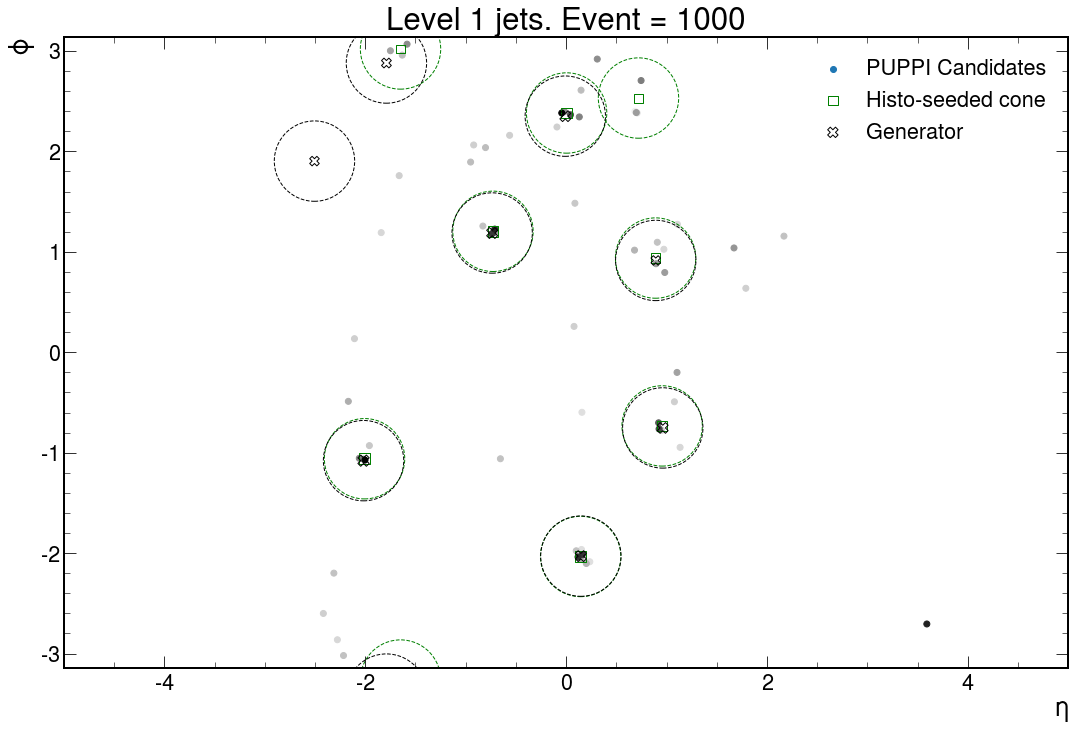

In [9]:
plotter([one, gen], jetCap=8, Ev=1000, jetCircle=True)

## Generating data

In [10]:
def seedAxisDiff(jetType, allEvs=True, distThresh=5):

    jetTypeNEW = jetType
    anoms = []
    nEvents = len(jetTypeNEW["pt"]) if allEvs == True else allEvs
    for ev in range(nEvents):
        jetEta = jetTypeNEW["eta"][ev]
        seedEta = jetTypeNEW["seeds"]["eta"][ev]

        jetPhi = jetTypeNEW["phi"][ev]
        seedPhi = jetTypeNEW["seeds"]["phi"][ev]
        
        distances = ((jetEta - seedEta)**2 + (jetPhi - seedPhi)**2)**0.5
        # distancesTruthTable = distances > distThresh
        # passedJetsIdx = [idx for idx, logic in enumerate(distancesTruthTable) if logic]
        # passedDistances = distances[distancesTruthTable]
        
        # for dist in passedJetsIdx:
        anoms.append(distances > distThresh)
        #anoms = np.append(anoms, [distances > distThresh], axis=0)
            #jetType["seeds"]["anom"].append(distances > distThresh)

    jetTypeNEW["seeds"]["anom"] = anoms
    
    return jetTypeNEW

In [ ]:
hsc

In [11]:
hsc2 = seedAxisDiff(hsc, allEvs = 100, distThresh=0.2)

In [51]:
hsc2["seeds"]["anom"]

[<Array [False, True, False, ... False, False] type='7 * bool'>,
 <Array [False, False, True, ... True, True] type='7 * bool'>,
 <Array [False, True, False, ... False, False] type='8 * bool'>,
 <Array [False, False, False, ... False, False] type='8 * bool'>,
 <Array [False, False, False, ... False, False] type='6 * bool'>,
 <Array [False, False, False, ... False, False] type='13 * bool'>,
 <Array [False, False, False, ... False, False] type='7 * bool'>,
 <Array [True, False, False, ... False, False] type='6 * bool'>,
 <Array [False, False, False, ... False, False] type='11 * bool'>,
 <Array [True, False, False, ... False, True] type='9 * bool'>,
 <Array [False, False, False, ... False, False] type='11 * bool'>,
 <Array [False, False, False, ... True, False] type='6 * bool'>,
 <Array [False, False, True, ... False, False] type='10 * bool'>,
 <Array [False, False, False, ... False, False] type='9 * bool'>,
 <Array [False, False, True, ... False, False] type='10 * bool'>,
 <Array [True, F

<AxesSubplot:title={'center':'Level 1 jets. Event = 1034'}, xlabel='$\\eta$', ylabel='$\\phi$'>

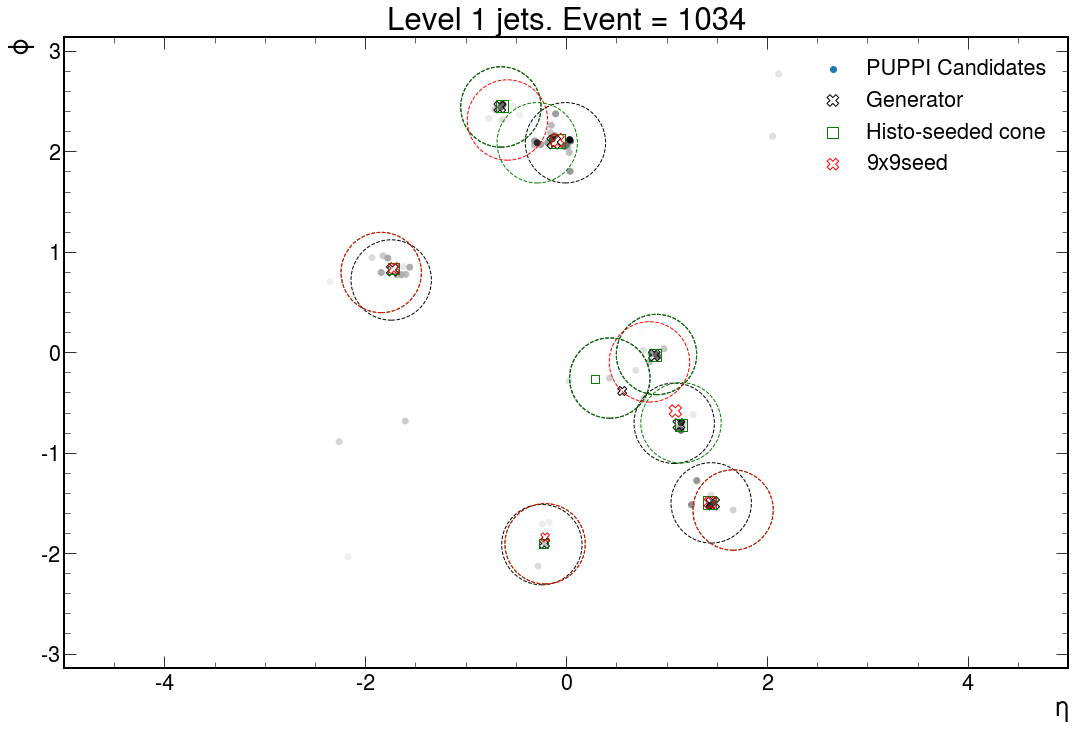

In [103]:
plotter([gen, hsc, nine], Ev=1034, jetCap=8, jetCircle=False)

In [12]:
def pairer(gen, jet, ev, r=0.4):
    """
    - Get a KDTree containing every sc jet
    - In a loop over every gen jet, query the tree with the gen jet
    - This will return the nearest sc jet to the gen jet
    """

    res = {
        "genXY"     : [],
        "jetXY"     : [],
        "seedXY"    : [],
        "dist"      : [],
        "eta_dist"  : [],
        "phi_dist"  : [],
        "pt"        : [],
        "unpaired"  : 0,
        "totalJets" : 0
    }
    
    jetXY, jetPt = list( zip(jet["seeds"]["eta"][ev], jet["seeds"]["phi"][ev]) ), jet["pt"][ev]
    genXY, genPt = list( zip(gen["eta"][ev], gen["phi"][ev]) ), gen["pt"][ev]
    if len(jetXY) == 0:
        res["unpaired"] = len(genPt)
        res["genXY"] = genXY
        return res
    
    jetKDT = KDTree(jetXY)
    for idx, genJet in enumerate(genXY):
        res["totalJets"] += 1
        dist, order = jetKDT.query(genJet)
        if dist < r:
            res["genXY"].append(genJet)
            res["jetXY"].append(jetXY[order])
            res["dist"].append(dist)
            res["pt"].append((genPt[idx] - jetPt[order]) / genPt[idx])
            res["eta_dist"].append(genJet[0] - jetXY[order][0])
            res["phi_dist"].append(genJet[1] - jetXY[order][1])
        else:
            res["unpaired"] += 1

    return res

In [13]:
def datCalc(jetAlgos, quant, gen=gen, events=len(gen["pt"])):
    assert quant in ["dist", "pt", "unpaired", "totalJets", "eta_dist", "phi_dist"]
    
    if quant == "unpaired" or quant == "totalJets":
        dic = {algo["name"]:0 for algo in jetAlgos}
    else:
        dic = {algo["name"]:[] for algo in jetAlgos}
    
    for algo in jetAlgos:
        for event in range(events):
            dat = pairer(gen=gen, jet=algo, ev=event)
            dic[algo["name"]] += dat[quant]

    return dic

In [23]:
pts = datCalc([hsc, three, five, seven, nine], quant="pt", events=10000)

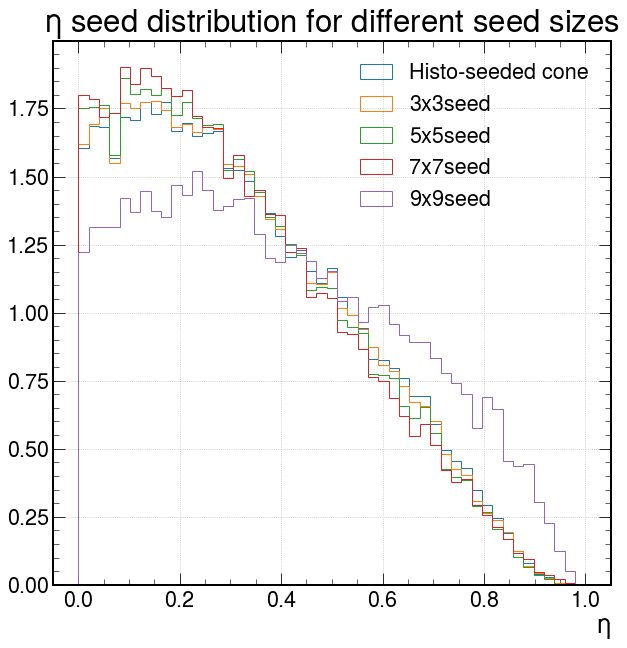

In [38]:
histPlotter(pts)

In [71]:
dists = datCalc([hsc, three, five, seven, nine], quant="dist", events=10000)

In [76]:
dists

{'Histo-seeded cone': [0.02735306083315663,
  0.012624651389164129,
  0.028020808033941684,
  0.008830173334584416,
  0.007774075656893692,
  0.025278469180189864,
  0.00755911426483347,
  0.029119729539189836,
  0.01686318400444103,
  0.0037592613611802726,
  0.032747613265829825,
  0.005467688154370087,
  0.09189991847722638,
  0.055594972208210344,
  0.020654232845221526,
  0.0350719705828025,
  0.02737502332635802,
  0.03453303290257597,
  0.039561471169370664,
  0.08095352177524273,
  0.048914103175694744,
  0.014731693401758405,
  0.02556289087146987,
  0.05237258316017407,
  0.024981281839082187,
  0.05171968691753418,
  0.030486171443411814,
  0.006102713004998554,
  0.016852506307803463,
  0.031185091861699914,
  0.136115773766581,
  0.01973313935898173,
  0.03890750009833322,
  0.04167864415316794,
  0.06569243558788634,
  0.02315757385706419,
  0.0013446442883607696,
  0.098406939960761,
  0.03829969608231558,
  0.01893180678145489,
  0.010285884372960217,
  0.08511523680370

In [81]:
for i in dists:
    print(i)

Histo-seeded cone
3x3seed
5x5seed
7x7seed
9x9seed


In [46]:
def histPlotter(var):

    binning=np.linspace(-0.4, 0.4, 100)
    for i in var:
        plt.hist(
            var[i],
            bins=binning,
            histtype="step",
            label=i,
            density=True
        )
    plt.legend()
    plt.xlabel("$\phi$")
    plt.title("$\phi$ seed resolution for different seed sizes")
    plt.grid()
    plt.show()

In [15]:
eta_dist_dat = datCalc([hsc, three, five, seven, nine], quant="eta_dist", events=10000)

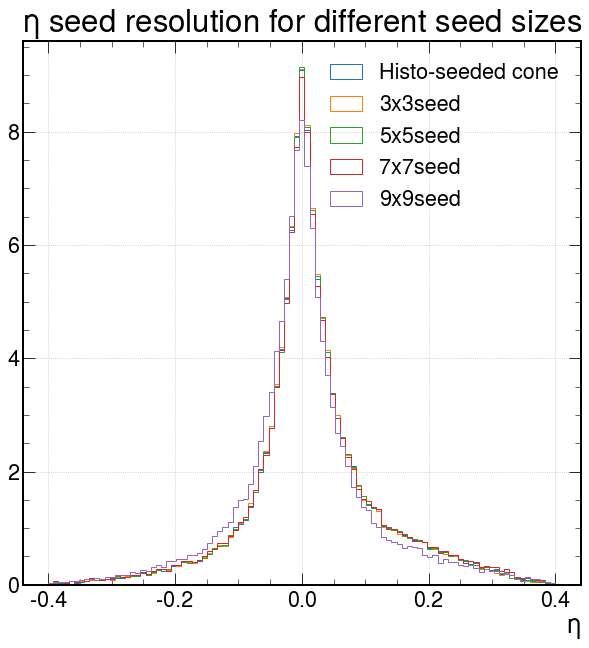

In [45]:
histPlotter(eta_dist_dat)

In [17]:
phi_dist_dat = datCalc([hsc, three, five, seven, nine], quant="phi_dist", events=10000)

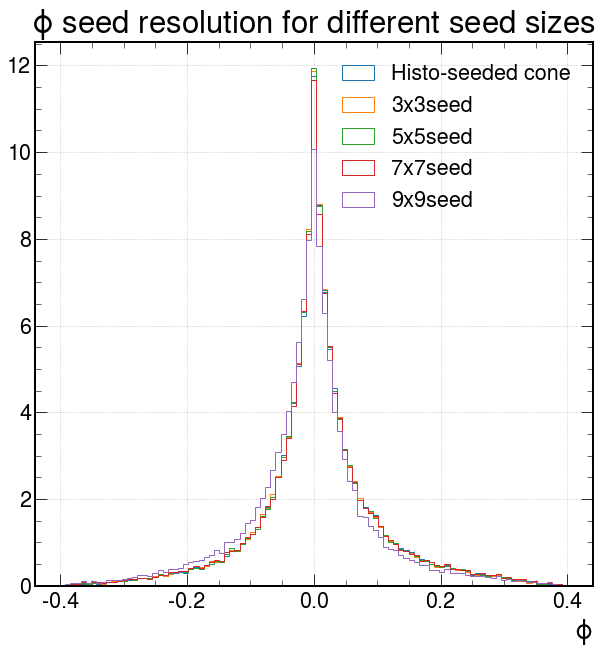

In [47]:
histPlotter(phi_dist_dat)

In [40]:
unpairedNums = datCalc([hsc, three, five, seven, nine], quant="unpaired", events=10000)

In [53]:
total_jets = datCalc([hsc, three, five, seven, nine], quant="totalJets", events=10000)

## Plotting data

In [ ]:
def resPlotter(data, nbins=100, quant=""):
    plt.figure(figsize=(10,6))
    
    if quant== "dist":
        binning = np.linspace(0, 0.4, nbins)
        plt.xlabel("Distance from gen jet")
        mplhep.cms.label(label="Preliminary. Distance between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    elif quant== "pt":
        binning = np.linspace(-1, 1, nbins)
        plt.xlabel("pT resolution")
        mplhep.cms.label(label="Preliminary. pT resolution between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    elif quant == "eta_dist":
        binning = np.linspace(-0.4, 0.4, nbins)
        plt.xlabel("Δη\Delta\eta")
        mplhep.cms.label(label="Preliminary. η\eta distance between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    elif quant == "phi_dist":
        binning = np.linspace(-0.4, 0.4, nbins)
        plt.xlabel("Δϕ\Delta\phi")
        mplhep.cms.label(label="Preliminary. ϕ\phi distance between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    else:
        raise Exception("Invalid quantity!")
        
    for key in data:
        if key == "sc":
            label = "SC"
        elif key == "hist":
            label = "Hist"
        elif key == "hsc":
            label = "HSC"
        plt.hist(
            data[key],
            histtype="step",
            bins = binning,
            #label=label,
            density=True
        )

    #mplhep.cms.label(label="Distance between gen jet and L1 jets".format(quant), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    #plt.title("pT resolution between gen jet and L1 jets".format(quant))
    #plt.xlabel("Distance from gen jet".format(quant))
    plt.legend()
    plt.grid()
    plt.show()
    
    return None

In [ ]:
resPlotter(pts, nbins=100, quant="pt")

In [ ]:
resPlotter(dists, nbins=100, quant="dist")

In [ ]:
resPlotter(eta_dist_dat, nbins=100, quant="eta_dist")

In [ ]:
resPlotter(phi_dist_dat, nbins=100, quant="phi_dist")

In [58]:
unp = {"1x1seed" if k == "Histo-seeded cone" else k:v for k,v in unpairedNums.items()}

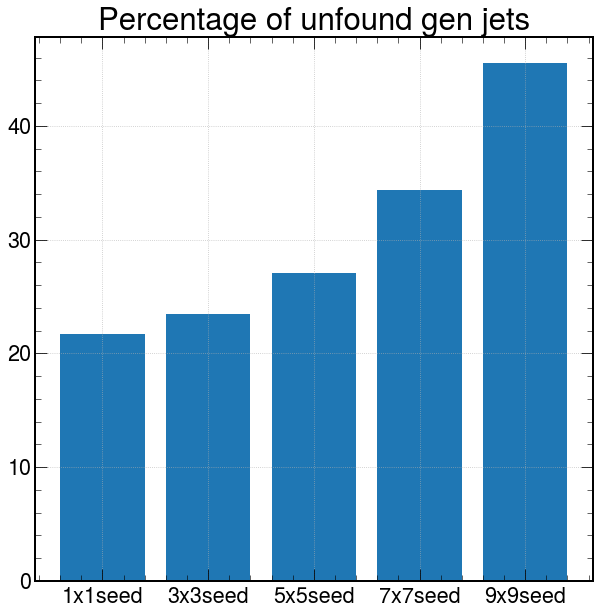

In [59]:
plt.bar(
    x = list(unp.keys()),
    height = (np.array( list(unp.values()) ) / np.array( list(total_jets.values()) ))*100,
)
plt.title("Percentage of unfound gen jets")
plt.grid()
#plt.ylim([30, 40])

## Jet seed studies

In [ ]:
ev=0
#hist["pt"][ev]
hist["eta"]

In [ ]:
cands["eta"][ev]

In [ ]:
pairer(gen=gen, jet=sc, ev=0)

In [ ]:
def highestPtCand(jetAlgo, event):
    highestPtCoords = (jetAlgo["eta"][event][0], jetAlgo["phi"][event][0])
    